# Regional Data

Use a shapefile to analyse solar data in specified regions only (e.g. capital cities). Regions can retain spatial resolution, or agreggated into a single datapoint.

This notebook only analyses data from a single day, to demonstrate how to use shapefiles to mask the netcdf files.

In [1]:
from netCDF4 import Dataset
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, box
from shapely.vectorized import contains

In [2]:
# Hard coded variables
year = 2023
month = 1
day = 1
hour = 23
minute = 30
utc_dt = datetime(year, month, day, hour, minute)
dir_dt = utc_dt + timedelta(hours=5, minutes=30)
num_days = 10
maxv=800

regions = [
    '1GSYD',
    '2GMEL',
    '3GBRI',
    '4GADE',
    '5GPER',
    '6GHOB',
    '7GDAR',
    '8ACTE'
]

In [3]:
# Load data

# https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files
gccsa_file = '/home/548/cd3022/aus-historical-solar-droughts/data/boundary_files/GCCSA/GCCSA_2021_AUST_GDA2020.shp'
gccsa = gpd.read_file(gccsa_file, encoding='utf-8')
gccsa = gccsa.to_crs("EPSG:4326")

all_regions = gccsa[gccsa['GCC_CODE21'].isin(regions)]

# Find number of files in each directory
dirin='/g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/latest/'+f"{dir_dt.year:04}"+'/'+f"{dir_dt.month:02}"+'/'+f"{dir_dt.day:02}"+"/"
file_count = len([f for f in os.listdir(dirin) if os.path.isfile(os.path.join(dirin, f))])

# Find lat/lon indices to use on all datasets
file_dt = utc_dt.strftime("%Y%m%d%H%M")
filename='IDE00326.'+file_dt+'.nc'
dataset = Dataset(dirin+filename)

latitudes = dataset.variables['latitude'][:]
longitudes = dataset.variables['longitude'][:]
irradiance = np.squeeze(dataset.variables['surface_global_irradiance'][:,:,:])

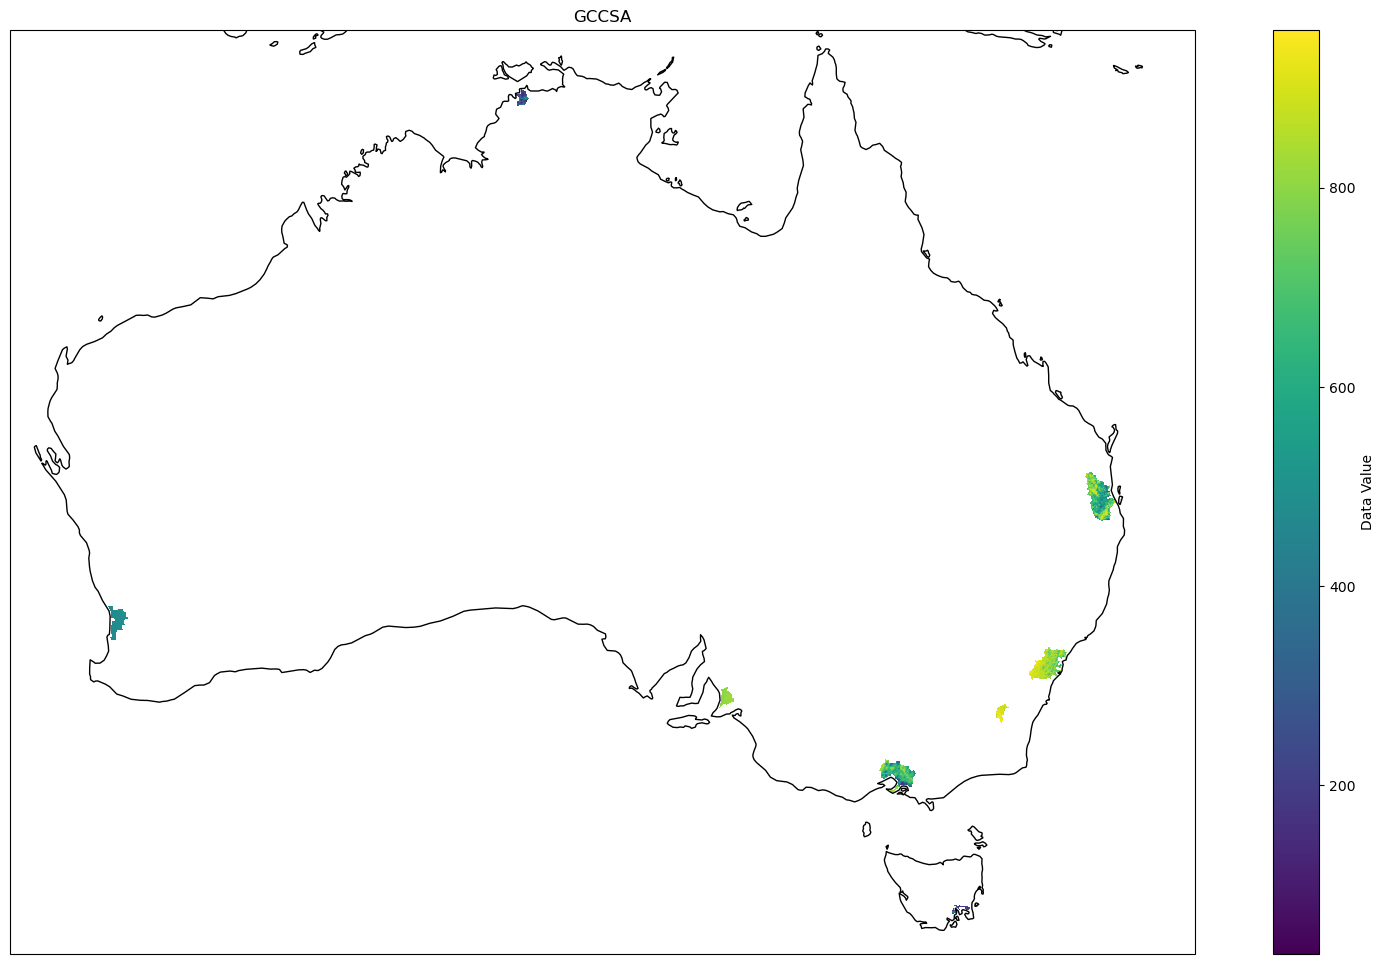

In [4]:
# Prepare masking variables and test mask

# Create a meshgrid of latitudes and longitudes
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# Flatten the grids into 1D arrays
lon_flat = lon_grid.ravel()
lat_flat = lat_grid.ravel()

# Vectorized check: Flattened grid of points
points = np.array([lon_flat, lat_flat]).T

# Check which points are inside the polygon(s)
mask_flat = contains(all_regions.unary_union, lon_flat, lat_flat)

# Reshape back to the grid shape
mask = mask_flat.reshape(lon_grid.shape)

# Apply the mask
masked_data = np.ma.masked_where(~mask, irradiance)

# Plot or process
# Create a figure with Cartopy's GeoAxes
fig, ax = plt.subplots(figsize=(20, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
# Use `extent` if needed to zoom into the relevant area
extent = [longitudes.min(), longitudes.max(), latitudes.min(), latitudes.max()]
img = ax.imshow(masked_data, cmap='viridis', origin='lower', extent=extent, transform=ccrs.PlateCarree())

ax.coastlines()
plt.colorbar(img, ax=ax, label='Data Value')
plt.title('GCCSA')
plt.show()

In [5]:
# Prepare the mask for all regions at once
region_masks = np.array([
    contains(gccsa[gccsa['GCC_CODE21'] == city].unary_union, lon_flat, lat_flat).reshape(lon_grid.shape)
    for city in regions
])

# Calculate the mean irradiance for each region
masked_data = np.ma.masked_array(np.repeat(irradiance[None, ...], len(regions), axis=0), mask=~region_masks)
region_means = masked_data.mean(axis=(1, 2))

# Create mean arrays for all regions
mean_arrays = np.ma.masked_array(
    np.broadcast_to(region_means[:, None, None], region_masks.shape), mask=~region_masks
)

[829.3473100000001 --]


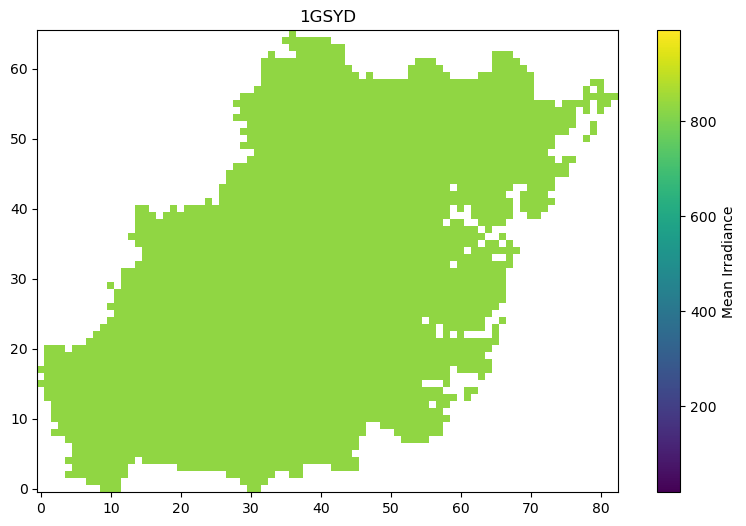

[626.5955712050078 --]


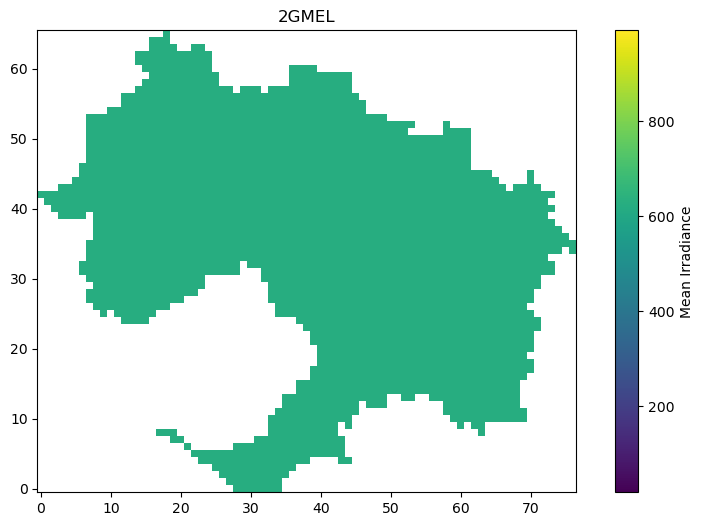

[683.4137834852254 --]


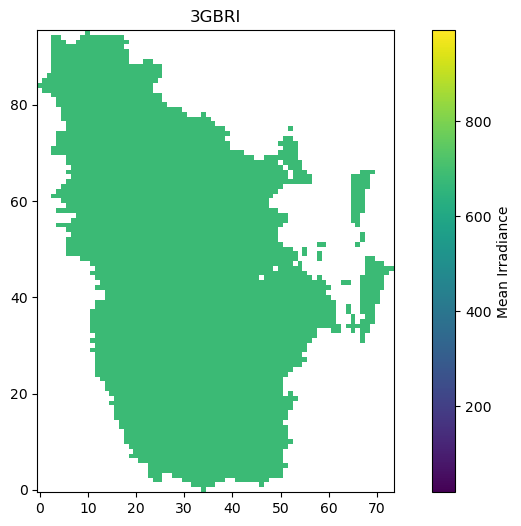

[807.5657783312578 --]


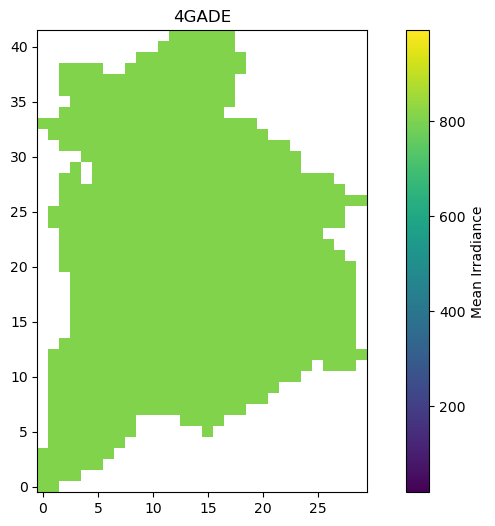

[481.6972057856674 --]


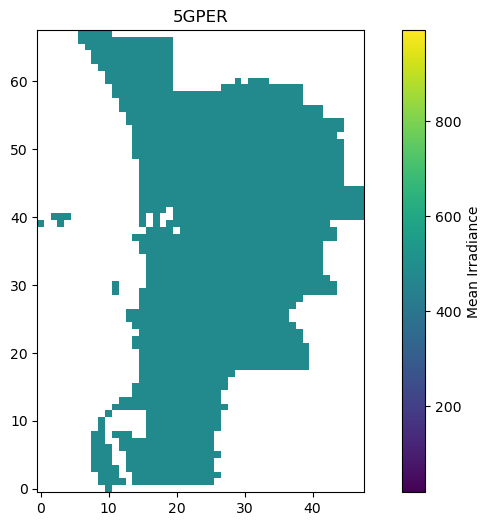

[243.06957356076757 --]


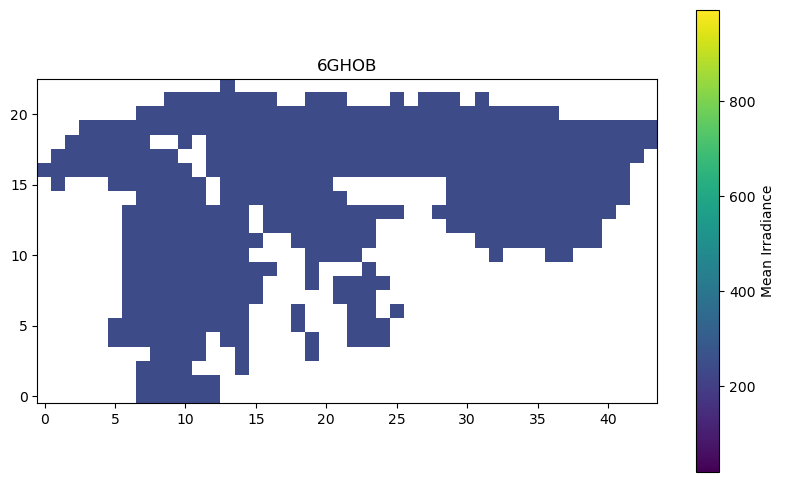

[272.3634446130501 --]


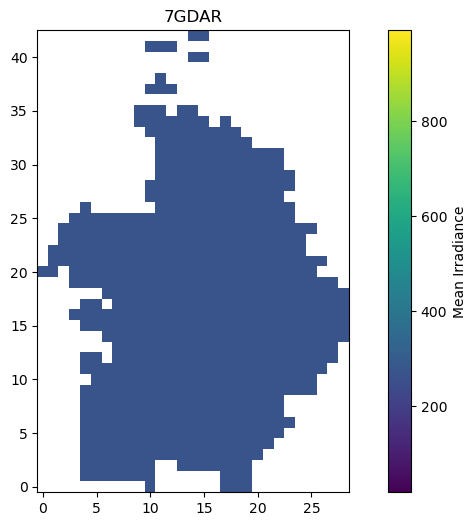

[905.7587951807228 --]


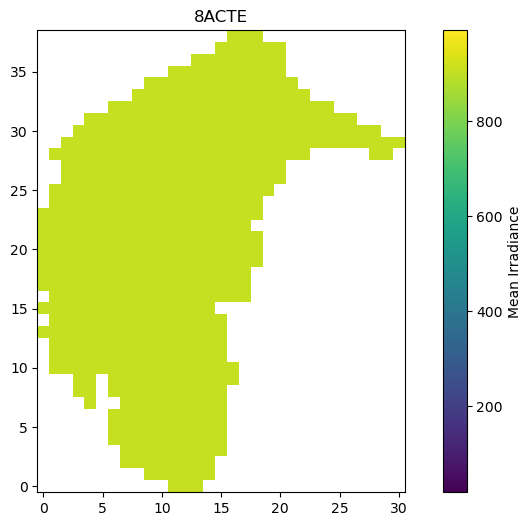

In [6]:
# Visualize each region
for i, city in enumerate(regions):
    # Get the mask for the current region
    # Regions stored in arrays in same order as "regions" list at beginning of script
    mask = region_masks[i]

    # Find the bounding box of the mask
    mask_indices = np.argwhere(mask)
    min_row, min_col = mask_indices.min(axis=0)
    max_row, max_col = mask_indices.max(axis=0)
    # Crop the irradiance and mask to the bounding box
    cropped_irradiance = mean_arrays[i][min_row:max_row + 1, min_col:max_col + 1]
    cropped_mask = mask[min_row:max_row + 1, min_col:max_col + 1]
    print(np.ma.unique(mean_arrays[i]))

    # Create a plot of the cropped area
    plt.figure(figsize=(10, 6))
    plt.imshow(
        np.ma.masked_where(~cropped_mask, cropped_irradiance),
        cmap='viridis',
        origin='lower',
        vmin=irradiance.min(),
        vmax=irradiance.max()
    )
    plt.colorbar(label='Mean Irradiance')
    plt.title(f'{city}')
    plt.show()